In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-genomics/cleaned_data_no_outliers.csv


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier
import warnings
import matplotlib.cm as cm
warnings.filterwarnings('ignore')

In [4]:
gdsc_data = pd.read_csv('/kaggle/input/cleaned-genomics/cleaned_data_no_outliers.csv')

In [5]:
gdsc_data.head().T

,0,1,2,3,4
COSMIC_ID,683667,687448,687452,687455,687457
CELL_LINE_NAME,PFSK-1,COLO-829,5637,RT4,SW780
TCGA_DESC,MB,SKCM,BLCA,BLCA,BLCA
DRUG_ID,1003,1003,1003,1003,1003
DRUG_NAME,Camptothecin,Camptothecin,Camptothecin,Camptothecin,Camptothecin
LN_IC50,-1.463887,-1.235034,-2.632632,-2.963191,-1.449138
AUC,0.93022,0.867348,0.834067,0.821438,0.90505
Z_SCORE,0.433123,0.557727,-0.203221,-0.3832,0.441154
GDSC Tissue descriptor 1,nervous_system,skin,Unknown,urogenital_system,urogenital_system
GDSC Tissue descriptor 2,medulloblastoma,melanoma,Unknown,Bladder,Bladder


In [6]:
gdsc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198342 entries, 0 to 198341
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                198342 non-null  int64  
 1   CELL_LINE_NAME                           198342 non-null  object 
 2   TCGA_DESC                                198342 non-null  object 
 3   DRUG_ID                                  198342 non-null  int64  
 4   DRUG_NAME                                198342 non-null  object 
 5   LN_IC50                                  198342 non-null  float64
 6   AUC                                      198342 non-null  float64
 7   Z_SCORE                                  198342 non-null  float64
 8   GDSC Tissue descriptor 1                 198342 non-null  object 
 9   GDSC Tissue descriptor 2                 198342 non-null  object 
 10  Cancer Type (matching TCGA label

In [7]:
# Data preprocessing
def preprocess_data(df):
    processed_df = df.copy()
    
    # Convert LN_IC50 to a binary classification task
    # Lower values indicate higher sensitivity
    sensitivity_threshold = processed_df['LN_IC50'].median()
    processed_df['Drug_Sensitive'] = (processed_df['LN_IC50'] < sensitivity_threshold).astype(int)
    print(f"Sensitivity threshold (median LN_IC50): {sensitivity_threshold:.4f}")
    
    # Select features for modeling
    features = [
        'TCGA_DESC', 'DRUG_ID', 'AUC', 'Z_SCORE',
        'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2',
        'Cancer Type (matching TCGA label)', 'Microsatellite instability Status (MSI)',
        'Screen Medium', 'Growth Properties', 'CNA', 'Gene Expression', 'Methylation',
        'TARGET', 'TARGET_PATHWAY'
    ]
    
    # Create feature matrix and target vector
    X = processed_df[features]
    y = processed_df['Drug_Sensitive']
    
    return X, y, processed_df

X, y, processed_data = preprocess_data(gdsc_data)

Sensitivity threshold (median LN_IC50): 3.5575


In [8]:
def encode_categorical_features(X):
    # Identify categorical features
    categorical_features = X.select_dtypes(include=['object']).columns
    numerical_features = X.select_dtypes(exclude=['object']).columns
    
    print(f"Categorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")
    
    X_encoded = X.copy()
    encoders = {}
    
    for feature in categorical_features:
        le = LabelEncoder()
        X_encoded[feature] = le.fit_transform(X[feature].astype(str))
        encoders[feature] = le
    
    if len(numerical_features) > 0:
        scaler = StandardScaler()
        X_encoded[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])
    
    return X_encoded

X_encoded = encode_categorical_features(X)
print("\nTransformed data sample:")
print(X_encoded.head())

Categorical features: 9
Numerical features: 6

Transformed data sample:
   TCGA_DESC   DRUG_ID       AUC   Z_SCORE  GDSC Tissue descriptor 1  \
0         18 -1.516275  0.075527  0.360484                        13   
1         27 -1.516275 -0.817682  0.500502                        16   
2          2 -1.516275 -1.290498 -0.354576                         0   
3          2 -1.516275 -1.469916 -0.556818                        19   
4          2 -1.516275 -0.282058  0.369508                        19   

   GDSC Tissue descriptor 2  Cancer Type (matching TCGA label)  \
0                        37                                 18   
1                        38                                 26   
2                         7                                 31   
3                         2                                  2   
4                         2                                  2   

   Microsatellite instability Status (MSI)  Screen Medium  Growth Properties  \
0                 

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

X_train.to_csv('X_train_transformed.csv', index=False)
X_test.to_csv('X_test_transformed.csv', index=False)

print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (138839, 15), (138839,)
Testing set shape: (59503, 15), (59503,)


In [10]:
X_train.head().T

,184213,125178,141898,62145,55132
TCGA_DESC,31.000000,8.000000,31.000000,17.000000,31.000000
DRUG_ID,1.299413,0.546026,0.642419,-0.572639,-1.016554
AUC,0.907987,0.518722,0.699418,0.909962,0.624107
Z_SCORE,-0.601400,-1.025549,-0.656102,1.105436,-0.664972
GDSC Tissue descriptor 1,11.000000,1.000000,2.000000,9.000000,11.000000
GDSC Tissue descriptor 2,10.000000,42.000000,43.000000,32.000000,4.000000
Cancer Type (matching TCGA label),31.000000,8.000000,31.000000,17.000000,31.000000
Microsatellite instability Status (MSI),1.000000,1.000000,1.000000,1.000000,1.000000
Screen Medium,1.000000,1.000000,0.000000,0.000000,1.000000
Growth Properties,2.000000,0.000000,0.000000,0.000000,2.000000


In [11]:
X_test.head().T

,175400,173880,147597,188281,113681
TCGA_DESC,16.000000,27.000000,4.000000,9.000000,9.000000
DRUG_ID,1.129457,1.124383,0.789545,1.413562,0.462316
AUC,-1.558964,-0.542554,-2.820683,0.341478,0.828714
Z_SCORE,-1.237680,-0.573948,-1.399440,-0.133074,0.613393
GDSC Tissue descriptor 1,9.000000,16.000000,19.000000,13.000000,13.000000
GDSC Tissue descriptor 2,28.000000,38.000000,14.000000,20.000000,20.000000
Cancer Type (matching TCGA label),16.000000,26.000000,4.000000,9.000000,9.000000
Microsatellite instability Status (MSI),1.000000,1.000000,1.000000,1.000000,1.000000
Screen Medium,0.000000,1.000000,0.000000,0.000000,1.000000
Growth Properties,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
# Split the original features (before encoding) for comparison
X_original_train, X_original_test, _, _ = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Save the original feature splits (before transformation)
X_original_train.to_csv('X_train_original.csv', index=False)
X_original_test.to_csv('X_test_original.csv', index=False)
print(f"Saved original feature splits to CSV files in 'data_output/' directory")

Saved original feature splits to CSV files in 'data_output/' directory


In [13]:
X_original_train.head().T

,184213,125178,141898,62145,55132
TCGA_DESC,UNCLASSIFIED,ESCA,UNCLASSIFIED,LUSC,UNCLASSIFIED
DRUG_ID,2113,1816,1854,1375,1200
AUC,0.988816,0.961416,0.974135,0.988955,0.968834
Z_SCORE,-0.422874,-0.800332,-0.471554,1.096069,-0.479448
GDSC Tissue descriptor 1,lymphoma,aero_dig_tract,bone,lung_NSCLC,lymphoma
GDSC Tissue descriptor 2,anaplastic_large_cell_lymphoma,oesophagus,osteosarcoma,lung_NSCLC_squamous_cell_carcinoma,Hodgkin_lymphoma
Cancer Type (matching TCGA label),Unknown,ESCA,Unknown,LUSC,Unknown
Microsatellite instability Status (MSI),MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L
Screen Medium,R,R,D/F12,D/F12,R
Growth Properties,Suspension,Adherent,Adherent,Adherent,Suspension


In [14]:
X_original_test.head().T

,175400,173880,147597,188281,113681
TCGA_DESC,LUAD,SKCM,CESC,GBM,GBM
DRUG_ID,2046,2044,1912,2158,1783
AUC,0.81517,0.886714,0.726359,0.94894,0.983236
Z_SCORE,-0.989111,-0.398444,-1.133064,-0.006103,0.658191
GDSC Tissue descriptor 1,lung_NSCLC,skin,urogenital_system,nervous_system,nervous_system
GDSC Tissue descriptor 2,lung_NSCLC_adenocarcinoma,melanoma,cervix,glioma,glioma
Cancer Type (matching TCGA label),LUAD,SKCM,CESC,GBM,GBM
Microsatellite instability Status (MSI),MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L
Screen Medium,D/F12,R,D/F12,D/F12,R
Growth Properties,Adherent,Adherent,Adherent,Adherent,Adherent


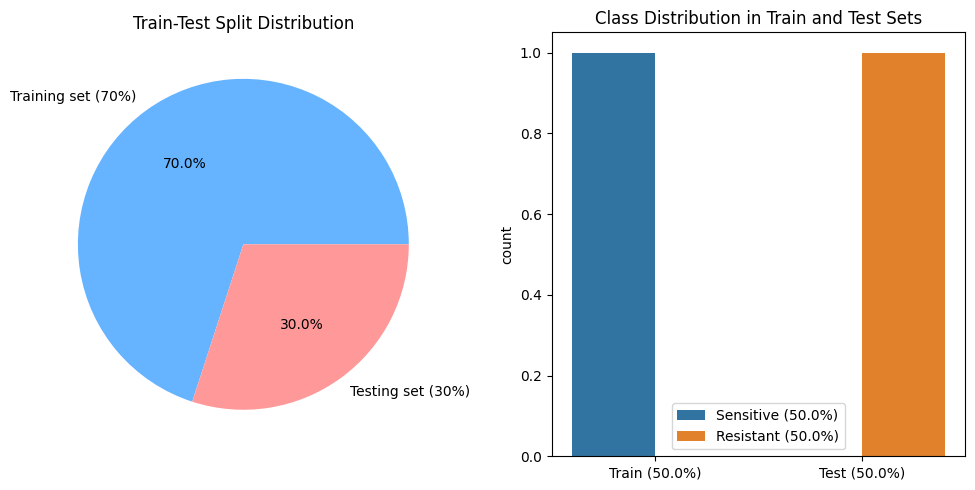

In [15]:
# Visualize the train-test split
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie([len(X_train), len(X_test)], labels=['Training set (70%)', 'Testing set (30%)'], 
        autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Train-Test Split Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x=[f"Train ({y_train.value_counts()[1]/len(y_train)*100:.1f}%)", 
                f"Test ({y_test.value_counts()[1]/len(y_test)*100:.1f}%)"],
             hue=[f"Sensitive ({(y_train.value_counts()[1] + y_test.value_counts()[1])/len(y)*100:.1f}%)", 
                  f"Resistant ({(y_train.value_counts()[0] + y_test.value_counts()[0])/len(y)*100:.1f}%)"])
plt.title('Class Distribution in Train and Test Sets')
plt.tight_layout()
plt.savefig('train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Function to train and evaluate models
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create visualizations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Resistant', 'Sensitive'],
                yticklabels=['Resistant', 'Sensitive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title(f'Top 15 Feature Importances - {model_name}')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': cr['1']['precision'],
        'recall': cr['1']['recall'],
        'f1': cr['1']['f1-score'],
        'confusion_matrix': cm,
        'classification_report': cr
    }

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, random_state=42)


Random Forest Results:
Accuracy: 0.9493

Confusion Matrix:
[[28334  1418]
 [ 1596 28155]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29752
           1       0.95      0.95      0.95     29751

    accuracy                           0.95     59503
   macro avg       0.95      0.95      0.95     59503
weighted avg       0.95      0.95      0.95     59503



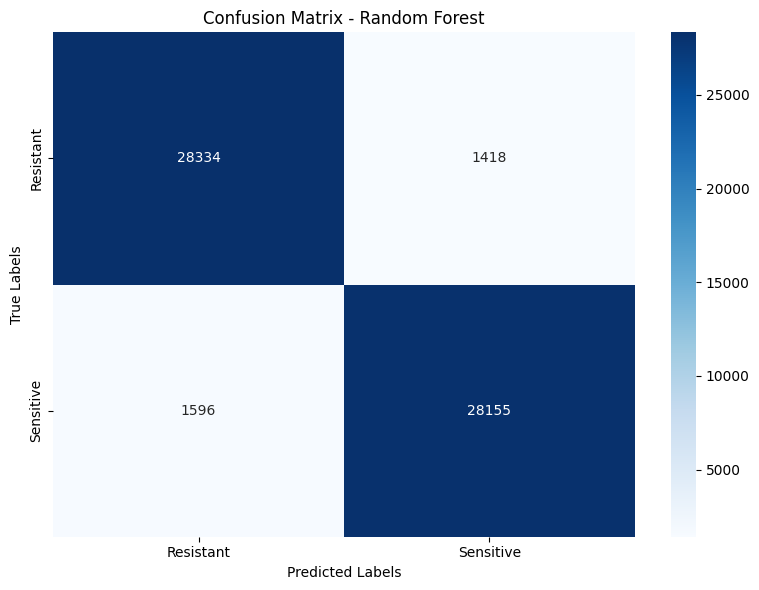

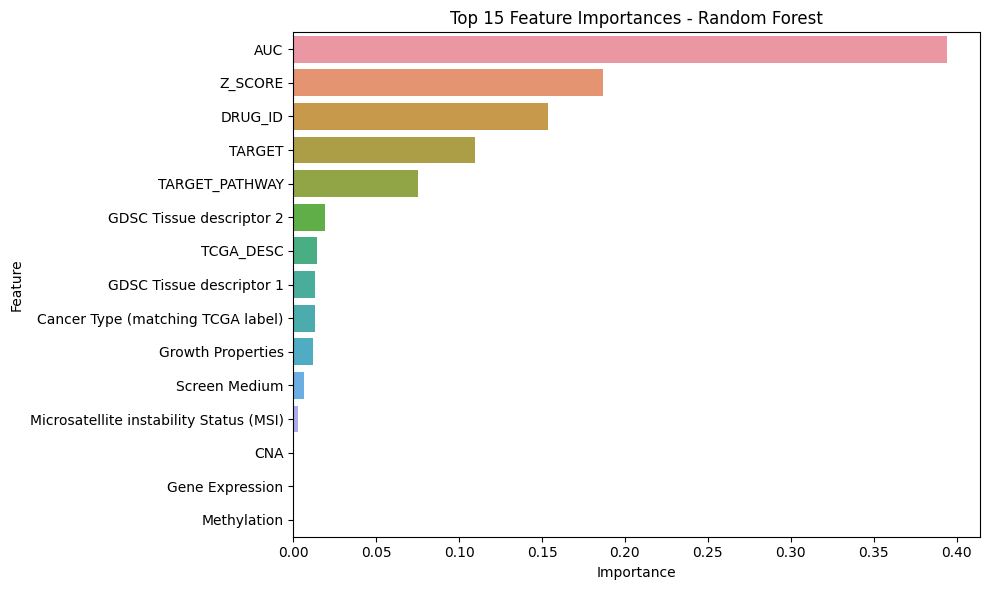


AdaBoost Results:
Accuracy: 0.8509

Confusion Matrix:
[[26394  3358]
 [ 5513 24238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     29752
           1       0.88      0.81      0.85     29751

    accuracy                           0.85     59503
   macro avg       0.85      0.85      0.85     59503
weighted avg       0.85      0.85      0.85     59503



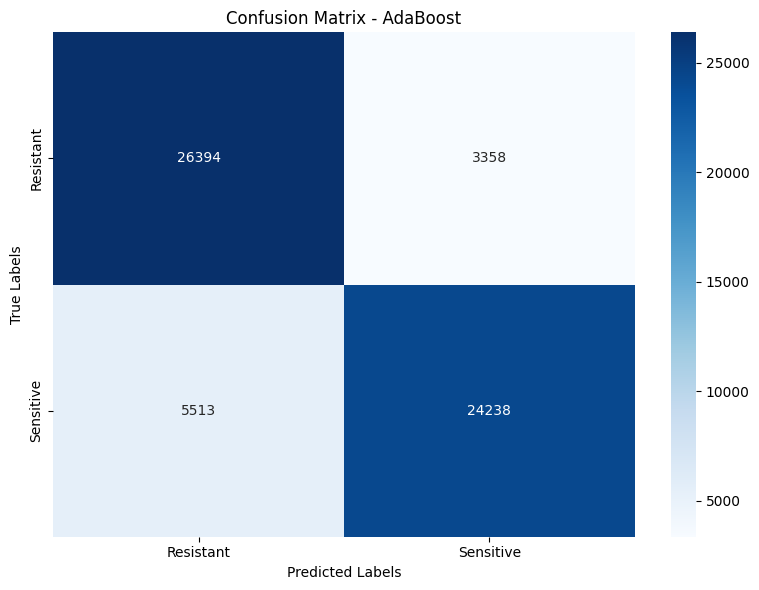

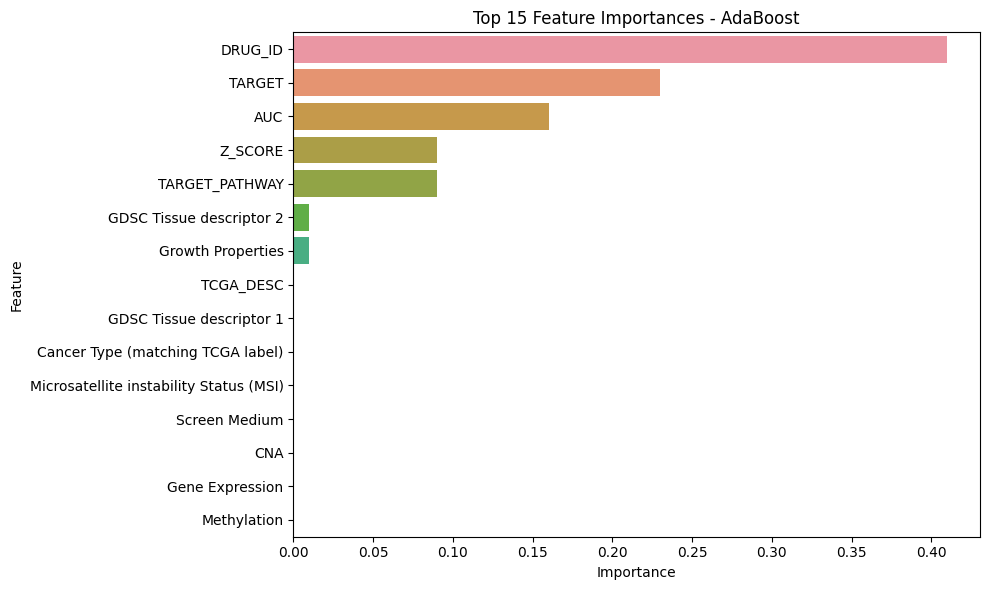


XGBoost Results:
Accuracy: 0.9864

Confusion Matrix:
[[29354   398]
 [  413 29338]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29752
           1       0.99      0.99      0.99     29751

    accuracy                           0.99     59503
   macro avg       0.99      0.99      0.99     59503
weighted avg       0.99      0.99      0.99     59503



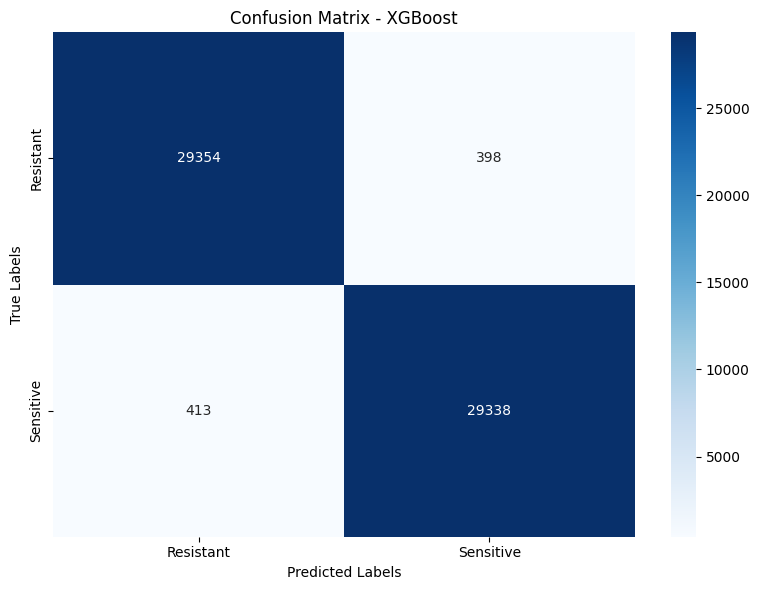

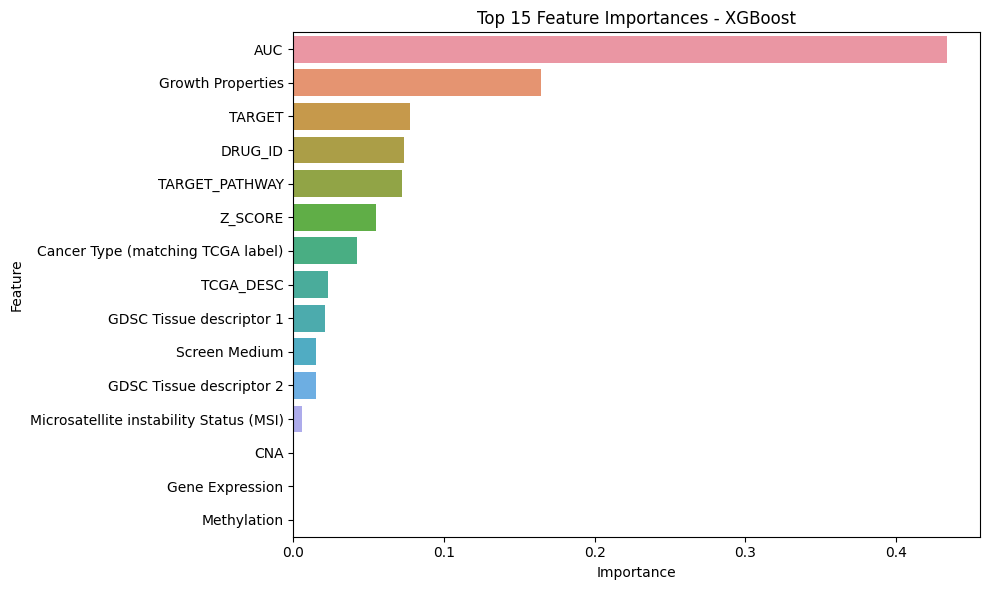

In [17]:
# Train and evaluate models
results = {}
results['Random Forest'] = train_evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'Random Forest')
results['AdaBoost'] = train_evaluate_model(ada_model, X_train, y_train, X_test, y_test, 'AdaBoost')
results['XGBoost'] = train_evaluate_model(xgb_model, X_train, y_train, X_test, y_test, 'XGBoost')

In [18]:
# Compare model performances
metrics = ['accuracy', 'precision', 'recall', 'f1']
performance_df = pd.DataFrame({
    metric: [results[model][metric] for model in results] 
    for metric in metrics
}, index=results.keys())

print("\nModel Performance Comparison:")
print(performance_df)


Model Performance Comparison:
               accuracy  precision    recall        f1
Random Forest  0.949347   0.952051  0.946355  0.949194
AdaBoost       0.850915   0.878316  0.814695  0.845310
XGBoost        0.986370   0.986616  0.986118  0.986367


<Figure size 1200x800 with 0 Axes>

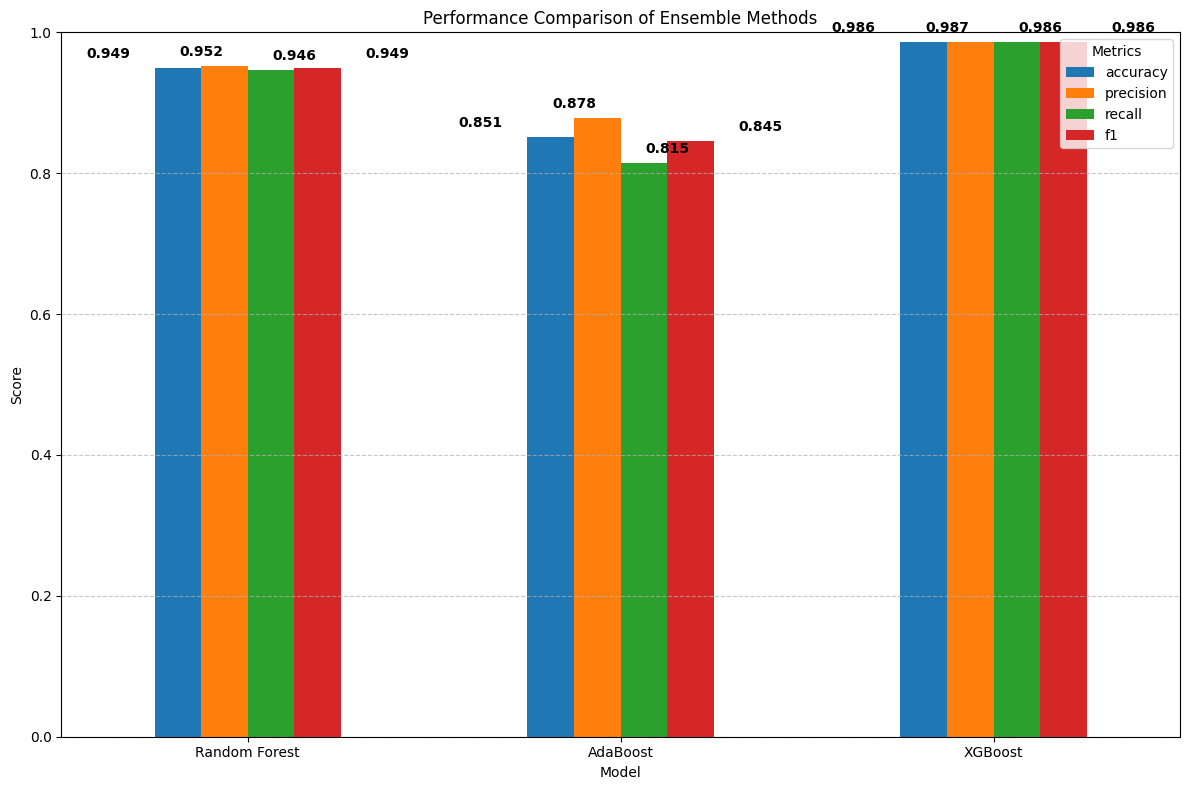

In [19]:
# Visualize model comparison
plt.figure(figsize=(12, 8))
performance_df.plot(kind='bar', figsize=(12, 8))
plt.title('Performance Comparison of Ensemble Methods')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrics')
for i, model in enumerate(performance_df.index):
    for j, metric in enumerate(performance_df.columns):
        plt.text(i + (j-1.5)/4, performance_df.loc[model, metric] + 0.01, 
                 f'{performance_df.loc[model, metric]:.3f}', 
                 ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Show data transformation details
print("\nData Transformation Summary:")
print(f"Original data dimensions: {gdsc_data.shape}")
print(f"Processed data dimensions: {processed_data.shape}")
print(f"Input features after encoding: {X_encoded.shape}")


Data Transformation Summary:
Original data dimensions: (198342, 19)
Processed data dimensions: (198342, 20)
Input features after encoding: (198342, 15)


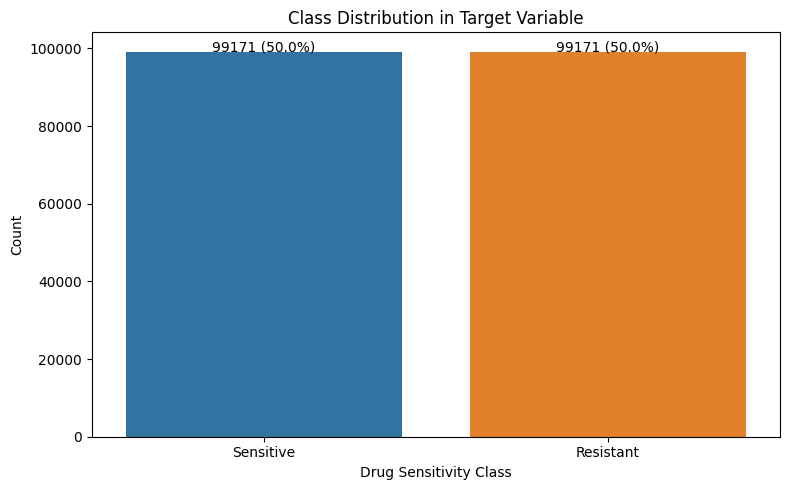

In [21]:
# Display class distribution
plt.figure(figsize=(8, 5))
class_counts = y.value_counts()
sns.barplot(x=class_counts.index.map({0: 'Resistant', 1: 'Sensitive'}), y=class_counts.values)
plt.title('Class Distribution in Target Variable')
plt.xlabel('Drug Sensitivity Class')
plt.ylabel('Count')
for i, count in enumerate(class_counts):
    plt.text(i, count + 100, f'{count} ({count/len(y)*100:.1f}%)', ha='center')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Display sample rows before and after transformation
comparison_df = pd.DataFrame({
    'Original': gdsc_data.iloc[0].loc[X.columns],
    'Transformed': X_encoded.iloc[0]
})
print("\nSample transformation (first row):")
print(comparison_df)


Sample transformation (first row):
                                                Original  Transformed
TCGA_DESC                                             MB    18.000000
DRUG_ID                                             1003    -1.516275
AUC                                              0.93022     0.075527
Z_SCORE                                         0.433123     0.360484
GDSC Tissue descriptor 1                  nervous_system    13.000000
GDSC Tissue descriptor 2                 medulloblastoma    37.000000
Cancer Type (matching TCGA label)                     MB    18.000000
Microsatellite instability Status (MSI)        MSS/MSI-L     1.000000
Screen Medium                                          R     1.000000
Growth Properties                               Adherent     0.000000
CNA                                                    1     0.000000
Gene Expression                                        1     0.000000
Methylation                                           

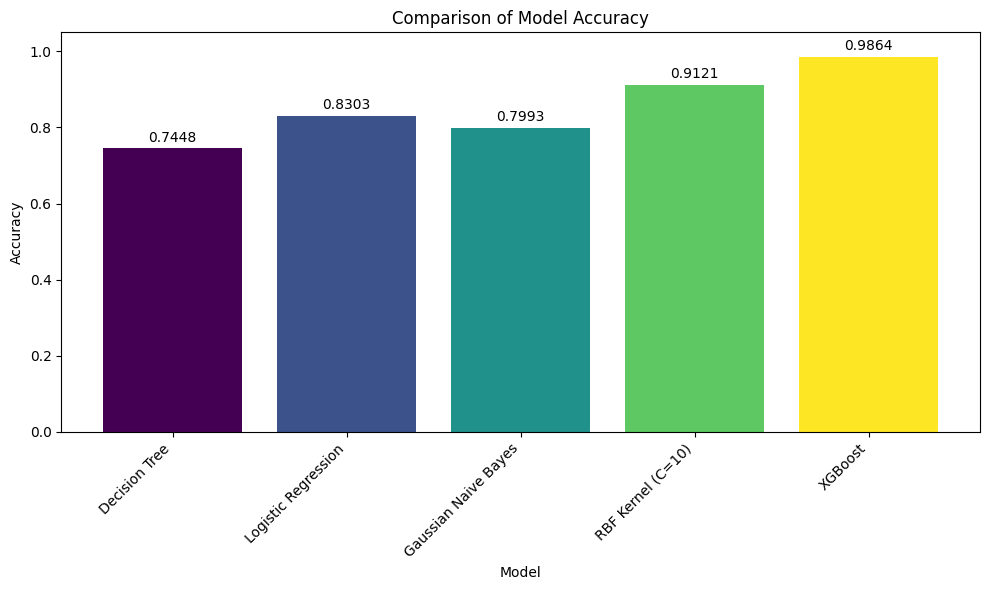

In [30]:
data = {
    'Model': ['Decision Tree', 'Logistic Regression', 'Gaussian Naive Bayes', 'RBF Kernel (C=10)', 'XGBoost'],
    'Accuracy': [0.7448, 0.8303, 0.7993, 0.9121, 0.9864]
}

df = pd.DataFrame(data)

# Choose a better color palette (e.g., 'viridis')
cmap = cm.get_cmap('viridis', len(df['Model']))
colors = [cmap(i) for i in range(cmap.N)]

# Create the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['Accuracy'], color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.ylim(0, 1.05) 
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.show()